In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
from datetime import datetime
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Configuration

In [2]:
# =============================================================================
# CONFIGURATION - Modify these paths as needed
# =============================================================================

# Data paths
SYNTHETIC_DATA_PATH = '/home/smotaali/BGP_Traffic_Generation/results/20251214_182312_exctracted_1s_FIXED.csv'
REAL_DATA_PATH = '/home/smotaali/BGP_Traffic_Generation/results/rrc04_20251116_exctracted_1s_FIXED.csv'


# Output directory for results
OUTPUT_DIR = '/home/smotaali/BGP_Traffic_Generation/results'

# Random seed for reproducibility
RANDOM_SEED = 42

# Significance level for statistical tests
ALPHA = 0.05

# Columns to exclude from analysis
EXCLUDE_COLS = ['label', 'window_start', 'window_end']

print("Configuration set!")

Configuration set!


## 2. Load and Prepare Data

In [3]:
# Load datasets
synthetic_full = pd.read_csv(SYNTHETIC_DATA_PATH)
real_full = pd.read_csv(REAL_DATA_PATH)

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nSynthetic Data Shape: {synthetic_full.shape}")
print(f"Real Data Shape: {real_full.shape}")
print(f"\nSynthetic Labels:\n{synthetic_full['label'].value_counts()}")
print(f"\nReal Labels:\n{real_full['label'].value_counts()}")

DATASET OVERVIEW

Synthetic Data Shape: (29320, 30)
Real Data Shape: (86387, 30)

Synthetic Labels:
label
normal               20465
path_manipulation     2973
prefix_hijacking      2964
dos_attack            2918
Name: count, dtype: int64

Real Labels:
label
normal    86387
Name: count, dtype: int64


In [4]:
# Filter only normal traffic from synthetic data
synthetic_normal = synthetic_full[synthetic_full['label'] == 'normal'].copy()
real_normal = real_full[real_full['label'] == 'normal'].copy()

print(f"Synthetic Normal samples: {len(synthetic_normal)}")
print(f"Real Normal samples: {len(real_normal)}")

Synthetic Normal samples: 20465
Real Normal samples: 86387


In [5]:
# Sample equal amounts for fair comparison
n_samples = min(len(synthetic_normal), len(real_normal))
print(f"\nUsing {n_samples} samples from each dataset for comparison")

# Use all synthetic normal (smaller dataset)
synthetic_sampled = synthetic_normal.copy()

# Random sample from real data
np.random.seed(RANDOM_SEED)
real_sampled = real_normal.sample(n=n_samples, random_state=RANDOM_SEED).copy()

print(f"Synthetic sampled: {len(synthetic_sampled)}")
print(f"Real sampled: {len(real_sampled)}")


Using 20465 samples from each dataset for comparison
Synthetic sampled: 20465
Real sampled: 20465


In [6]:
# Get feature columns
feature_cols = [col for col in synthetic_sampled.columns if col not in EXCLUDE_COLS]
print(f"\nNumber of features to compare: {len(feature_cols)}")
print(f"\nFeatures: {feature_cols}")


Number of features to compare: 27

Features: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_avg', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'rare_ases_avg', 'nadas', 'flaps']


In [7]:
# Extract feature matrices
X_synthetic = synthetic_sampled[feature_cols].values
X_real = real_sampled[feature_cols].values

# Create DataFrames for analysis
df_synthetic = synthetic_sampled[feature_cols].copy()
df_real = real_sampled[feature_cols].copy()

print(f"Synthetic feature matrix shape: {X_synthetic.shape}")
print(f"Real feature matrix shape: {X_real.shape}")

Synthetic feature matrix shape: (20465, 27)
Real feature matrix shape: (20465, 27)


## 3. Descriptive Statistics Comparison

In [8]:
# Calculate descriptive statistics for both datasets
stats_synthetic = df_synthetic.describe().T
stats_real = df_real.describe().T

# Rename columns for clarity
stats_synthetic.columns = [f'syn_{col}' for col in stats_synthetic.columns]
stats_real.columns = [f'real_{col}' for col in stats_real.columns]

# Combine into comparison table
stats_comparison = pd.concat([stats_synthetic, stats_real], axis=1)

# Reorder columns for side-by-side comparison
ordered_cols = []
for stat in ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    ordered_cols.extend([f'syn_{stat}', f'real_{stat}'])
stats_comparison = stats_comparison[ordered_cols]
stats_comparison.to_csv(f'{OUTPUT_DIR}/phase1_descriptive_statistics_20251214_182312.csv')

print("Descriptive Statistics Comparison (Synthetic vs Real)")
print("=" * 80)
stats_comparison

Descriptive Statistics Comparison (Synthetic vs Real)


,syn_count,real_count,syn_mean,real_mean,syn_std,real_std,syn_min,real_min,syn_25%,real_25%,syn_50%,real_50%,syn_75%,real_75%,syn_max,real_max
announcements,20465.0,20465.0,15.646909,179.581920,9.020394,292.522609,1.0,0.0,9.000000,25.000000,14.000000,60.00000,20.000000,176.000000,368.0,7758.0
withdrawals,20465.0,20465.0,1.464598,15.099194,2.066461,60.089587,0.0,0.0,0.000000,1.000000,1.000000,3.00000,2.000000,9.000000,20.0,2454.0
nlri_ann,20465.0,20465.0,3.294698,143.795065,1.083218,252.583615,1.0,0.0,3.000000,16.000000,3.000000,42.00000,4.000000,127.000000,89.0,7736.0
dups,20465.0,20465.0,3.641876,7.425556,4.056724,25.757313,0.0,0.0,1.000000,0.000000,3.000000,1.00000,5.000000,4.000000,284.0,682.0
origin_0,20465.0,20465.0,14.184168,0.000000,7.738446,0.000000,0.0,0.0,9.000000,0.000000,13.000000,0.00000,18.000000,0.000000,368.0,0.0
origin_2,20465.0,20465.0,0.000440,0.000000,0.040155,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,4.0,0.0
origin_changes,20465.0,20465.0,0.000244,0.000000,0.020970,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.0,0.0
imp_wd,20465.0,20465.0,8.087906,12.313902,4.934218,37.042907,0.0,0.0,4.000000,1.000000,7.000000,3.00000,11.000000,8.000000,123.0,990.0
imp_wd_spath,20465.0,20465.0,0.007232,2.596531,0.783458,18.212763,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,108.0,466.0
imp_wd_dpath,20465.0,20465.0,8.080674,9.717371,4.860032,29.756514,0.0,0.0,4.000000,1.000000,7.000000,3.00000,11.000000,7.000000,52.0,916.0


In [9]:
# Calculate percentage difference in means
mean_diff = pd.DataFrame({
    'synthetic_mean': df_synthetic.mean(),
    'real_mean': df_real.mean()
})
mean_diff['abs_diff'] = abs(mean_diff['synthetic_mean'] - mean_diff['real_mean'])
mean_diff['pct_diff'] = (mean_diff['abs_diff'] / (mean_diff['real_mean'].abs() + 1e-10)) * 100
mean_diff = mean_diff.sort_values('pct_diff', ascending=False)
mean_diff.to_csv(f'{OUTPUT_DIR}/phase1_mean_diff_20251214_182312.csv')

print("\nMean Difference Analysis (sorted by % difference)")
print("=" * 60)
print(mean_diff.round(4))


Mean Difference Analysis (sorted by % difference)
                             synthetic_mean  real_mean  abs_diff      pct_diff
origin_0                            14.1842     0.0000   14.1842  1.418417e+13
origin_2                             0.0004     0.0000    0.0004  4.397752e+08
edit_distance_dict_0                 0.0003     0.0000    0.0003  3.420474e+08
origin_changes                       0.0002     0.0000    0.0002  2.443196e+08
edit_distance_unique_dict_0          0.0001     0.0000    0.0001  1.465917e+08
rare_ases_avg                        0.4161     0.1270    0.2892  2.277380e+02
edit_distance_dict_6                 0.4928     0.1810    0.3118  1.722732e+02
edit_distance_dict_4                 1.2858     0.4814    0.8044  1.670930e+02
edit_distance_dict_5                 0.6931     0.3019    0.3913  1.296051e+02
edit_distance_dict_3                 2.3954     1.1454    1.2500  1.091382e+02
nadas                                0.0013     2.6836    2.6823  9.995270e+01
f

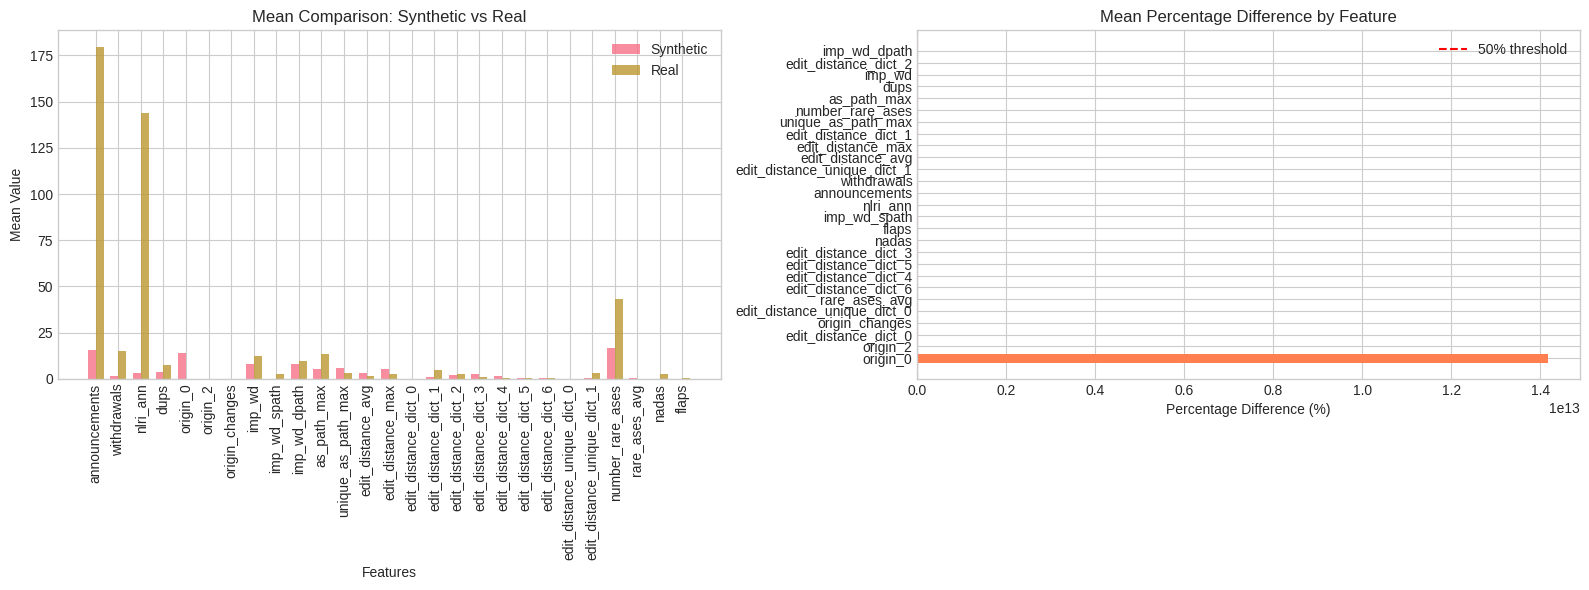

Saved: /home/smotaali/BGP_Traffic_Generation/results/01_mean_comparison.png


In [10]:
# Visualize mean comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of means
x = np.arange(len(feature_cols))
width = 0.35

axes[0].bar(x - width/2, df_synthetic.mean(), width, label='Synthetic', alpha=0.8)
axes[0].bar(x + width/2, df_real.mean(), width, label='Real', alpha=0.8)
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Mean Value')
axes[0].set_title('Mean Comparison: Synthetic vs Real')
axes[0].set_xticks(x)
axes[0].set_xticklabels(feature_cols, rotation=90)
axes[0].legend()

# Percentage difference
axes[1].barh(mean_diff.index, mean_diff['pct_diff'], color='coral')
axes[1].set_xlabel('Percentage Difference (%)')
axes[1].set_title('Mean Percentage Difference by Feature')
axes[1].axvline(x=50, color='red', linestyle='--', label='50% threshold')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/01_mean_comparison_20251214_182312.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/01_mean_comparison.png")

## 4. Distribution Comparison (KS-Test)

In [11]:
# Perform Kolmogorov-Smirnov test for each feature
ks_results = []

for col in feature_cols:
    stat, p_value = stats.ks_2samp(df_synthetic[col], df_real[col])
    ks_results.append({
        'feature': col,
        'ks_statistic': stat,
        'p_value': p_value,
        'similar_distribution': p_value > ALPHA
    })

ks_df = pd.DataFrame(ks_results)
ks_df = ks_df.sort_values('ks_statistic', ascending=False)
ks_df.to_csv(f'{OUTPUT_DIR}/phase1_ks_results_20251214_182312.csv')

print("Kolmogorov-Smirnov Test Results")
print("=" * 60)
print(f"Significance level (alpha): {ALPHA}")
print(f"\nFeatures with SIMILAR distributions: {ks_df['similar_distribution'].sum()}/{len(feature_cols)}")
print(f"Features with DIFFERENT distributions: {(~ks_df['similar_distribution']).sum()}/{len(feature_cols)}")
print("\n")
print(ks_df.to_string(index=False))

Kolmogorov-Smirnov Test Results
Significance level (alpha): 0.05

Features with SIMILAR distributions: 4/27
Features with DIFFERENT distributions: 23/27


                    feature  ks_statistic       p_value  similar_distribution
                   origin_0      0.999951  0.000000e+00                 False
                   nlri_ann      0.978304  0.000000e+00                 False
                as_path_max      0.716247  0.000000e+00                 False
          edit_distance_avg      0.697581  0.000000e+00                 False
              announcements      0.626924  0.000000e+00                 False
       edit_distance_dict_3      0.586172  0.000000e+00                 False
          edit_distance_max      0.583484  0.000000e+00                 False
              rare_ases_avg      0.583337  0.000000e+00                 False
       edit_distance_dict_4      0.477938  0.000000e+00                 False
           number_rare_ases      0.463865  0.000000e+00          

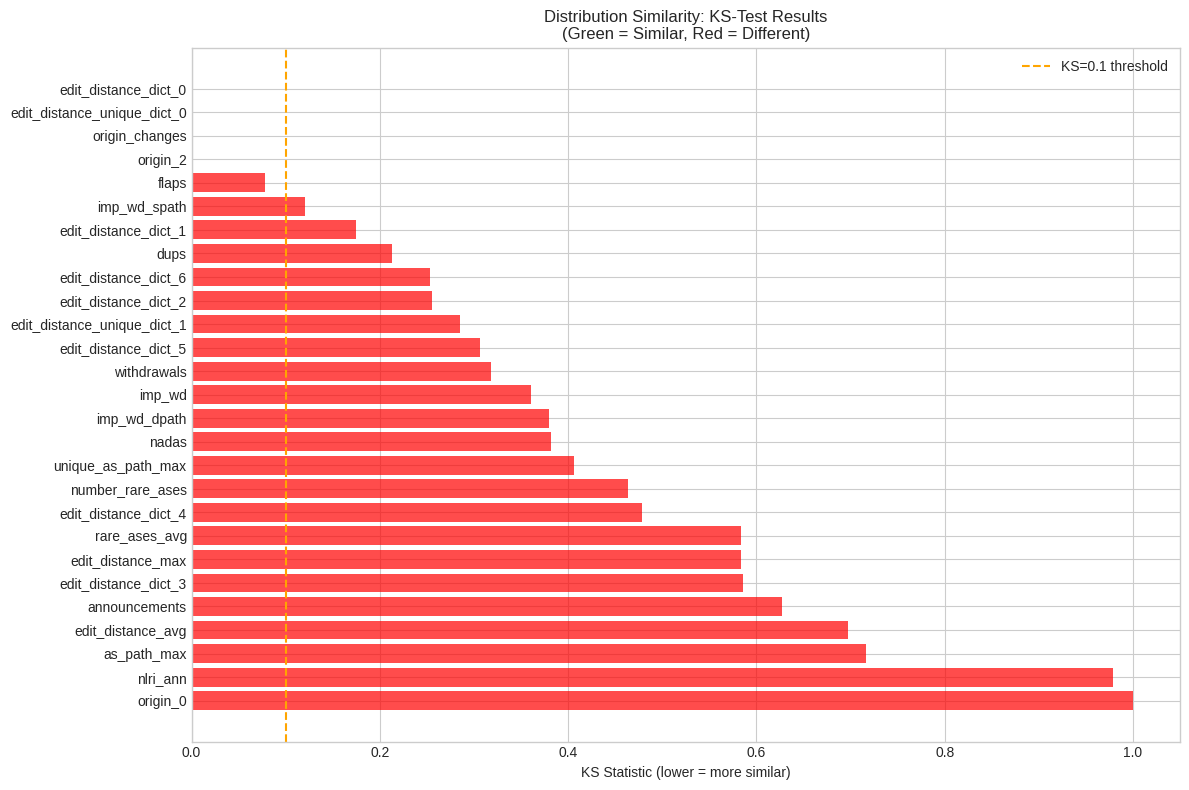

Saved: /home/smotaali/BGP_Traffic_Generation/results/02_ks_test_results.png


In [12]:
# Visualize KS statistics
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['green' if sim else 'red' for sim in ks_df['similar_distribution']]
bars = ax.barh(ks_df['feature'], ks_df['ks_statistic'], color=colors, alpha=0.7)

ax.set_xlabel('KS Statistic (lower = more similar)')
ax.set_title('Distribution Similarity: KS-Test Results\n(Green = Similar, Red = Different)')
ax.axvline(x=0.1, color='orange', linestyle='--', label='KS=0.1 threshold')
ax.legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_ks_test_results_20251214_182312.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/02_ks_test_results.png")

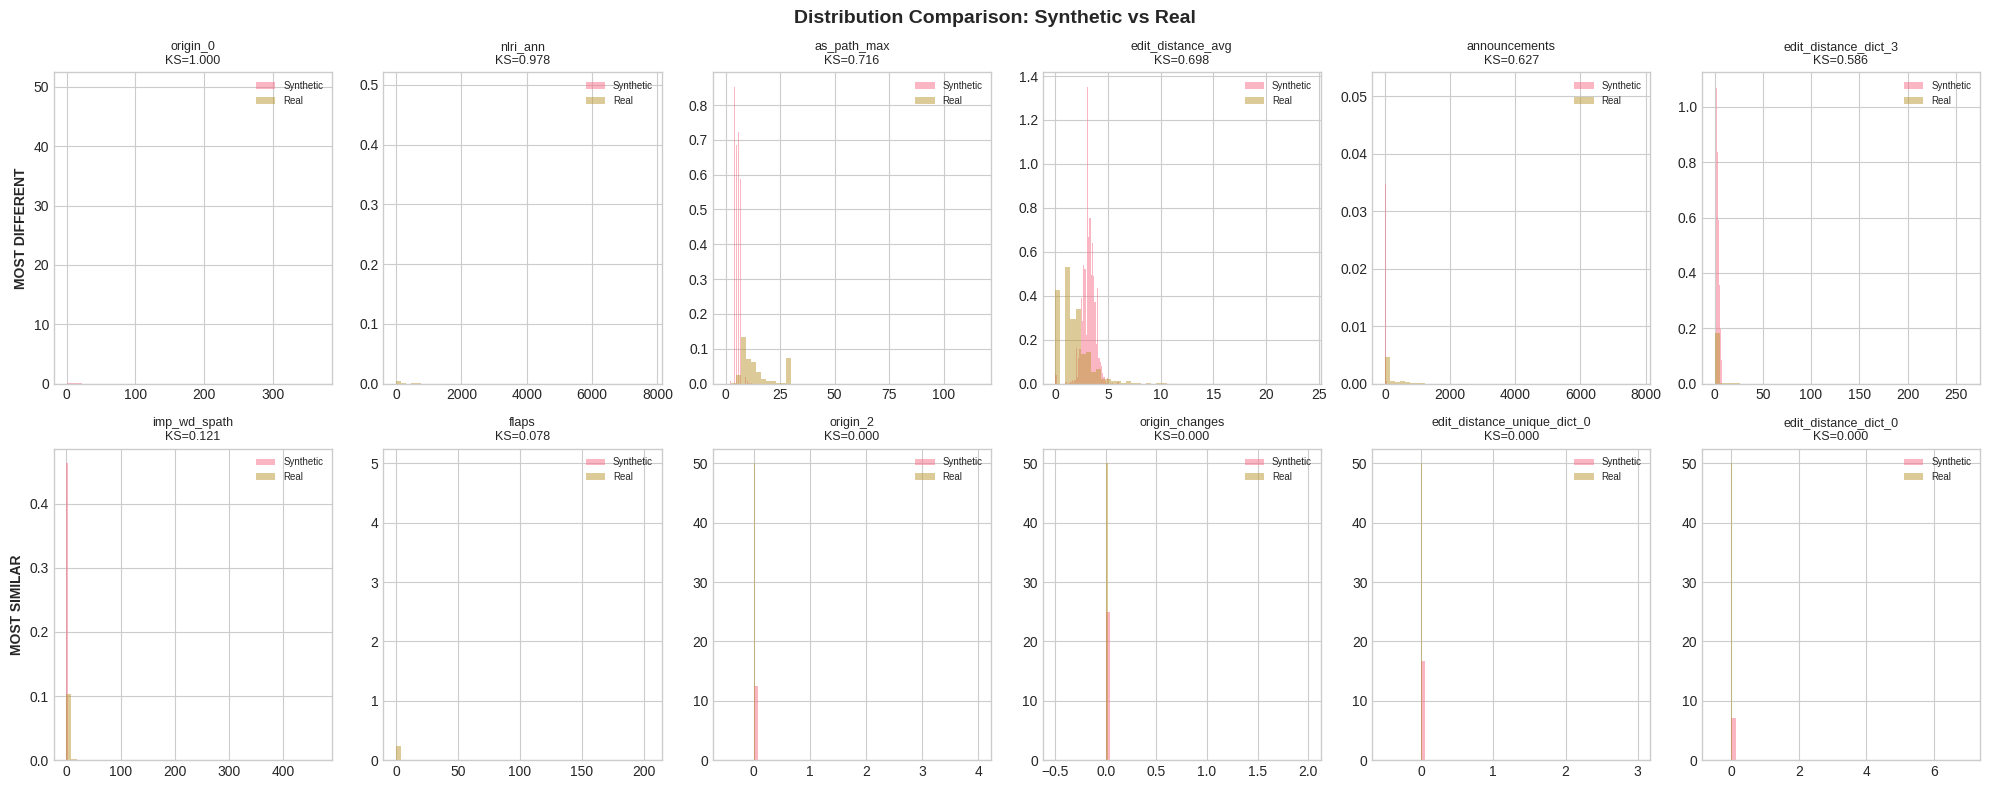

Saved: /home/smotaali/BGP_Traffic_Generation/results/03_distribution_comparison.png


In [13]:
# Plot distributions for top features (most different and most similar)
n_features_to_plot = 6

# Most different
most_different = ks_df.head(n_features_to_plot)['feature'].tolist()
# Most similar
most_similar = ks_df.tail(n_features_to_plot)['feature'].tolist()

fig, axes = plt.subplots(2, n_features_to_plot, figsize=(20, 8))

# Plot most different
for i, col in enumerate(most_different):
    ax = axes[0, i]
    ax.hist(df_synthetic[col], bins=50, alpha=0.5, label='Synthetic', density=True)
    ax.hist(df_real[col], bins=50, alpha=0.5, label='Real', density=True)
    ks_val = ks_df[ks_df['feature'] == col]['ks_statistic'].values[0]
    ax.set_title(f'{col}\nKS={ks_val:.3f}', fontsize=9)
    ax.legend(fontsize=7)
    if i == 0:
        ax.set_ylabel('MOST DIFFERENT', fontsize=10, fontweight='bold')

# Plot most similar
for i, col in enumerate(most_similar):
    ax = axes[1, i]
    ax.hist(df_synthetic[col], bins=50, alpha=0.5, label='Synthetic', density=True)
    ax.hist(df_real[col], bins=50, alpha=0.5, label='Real', density=True)
    ks_val = ks_df[ks_df['feature'] == col]['ks_statistic'].values[0]
    ax.set_title(f'{col}\nKS={ks_val:.3f}', fontsize=9)
    ax.legend(fontsize=7)
    if i == 0:
        ax.set_ylabel('MOST SIMILAR', fontsize=10, fontweight='bold')

plt.suptitle('Distribution Comparison: Synthetic vs Real', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/03_distribution_comparison_20251214_182312.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/03_distribution_comparison.png")

## 5. Correlation Analysis

In [14]:
# Remove constant columns (zero variance)
syn_std = df_synthetic.std()
real_std = df_real.std()
valid_cols = (syn_std > 1e-10) & (real_std > 1e-10)
print(f"Removed {(~valid_cols).sum()} constant columns: {list(valid_cols[~valid_cols].index)}")

df_syn_clean = df_synthetic.loc[:, valid_cols]
df_real_clean = df_real.loc[:, valid_cols]

# Now calculate correlations
corr_synthetic = df_syn_clean.corr()
corr_real = df_real_clean.corr()
corr_diff = abs(corr_synthetic - corr_real)

print(f"Mean absolute correlation difference: {corr_diff.values.mean():.4f}")
print(f"Max absolute correlation difference: {corr_diff.values.max():.4f}")

Removed 5 constant columns: ['origin_0', 'origin_2', 'origin_changes', 'edit_distance_dict_0', 'edit_distance_unique_dict_0']
Mean absolute correlation difference: 0.1975
Max absolute correlation difference: 0.6475


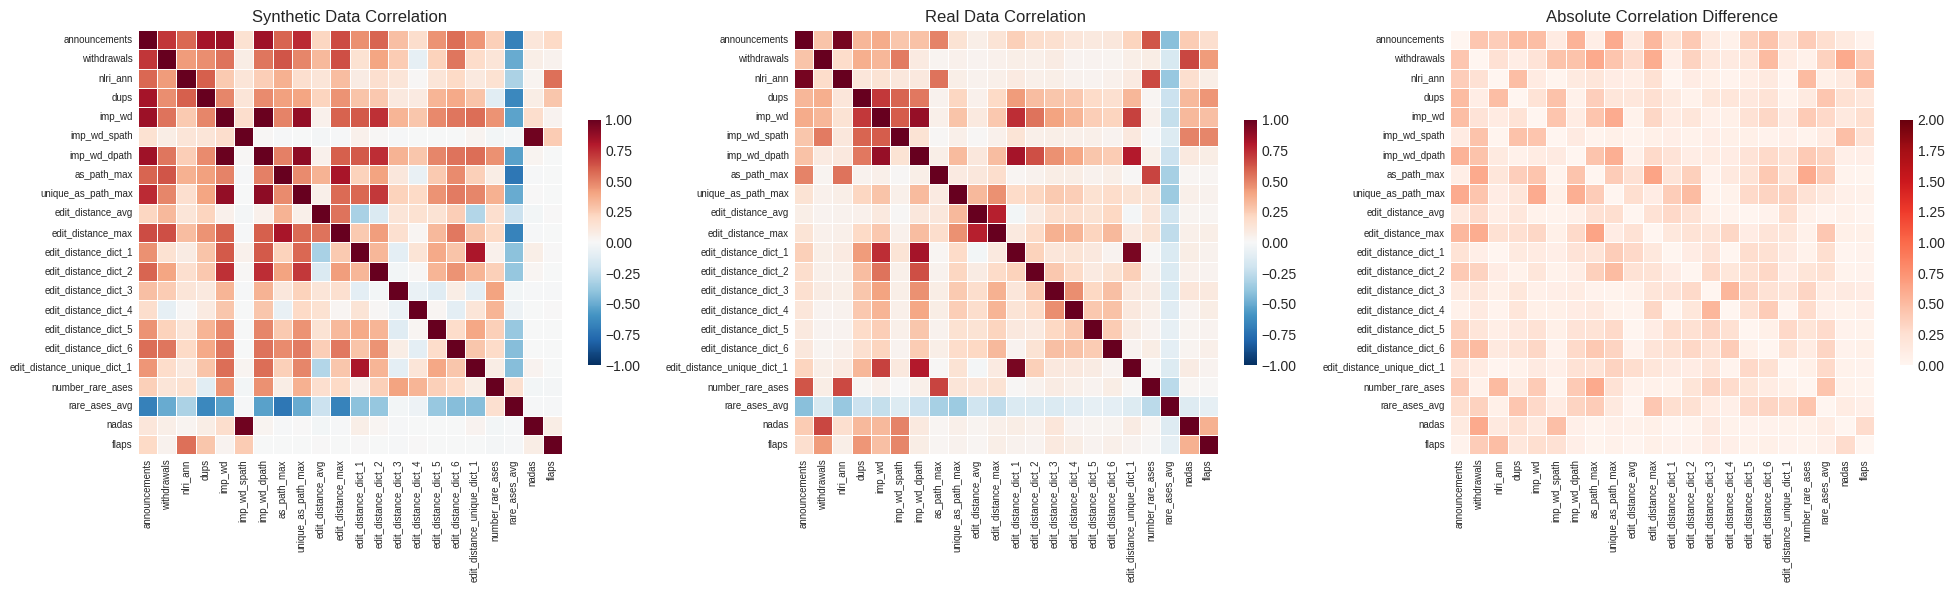

Saved: /home/smotaali/BGP_Traffic_Generation/results/04_correlation_comparison.png


In [15]:
# Plot correlation matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Synthetic correlation
sns.heatmap(corr_synthetic, ax=axes[0], cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5},
            vmin=-1, vmax=1)
axes[0].set_title('Synthetic Data Correlation', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, fontsize=7)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=7)

# Real correlation
sns.heatmap(corr_real, ax=axes[1], cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5},
            vmin=-1, vmax=1)
axes[1].set_title('Real Data Correlation', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, fontsize=7)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=7)

# Difference
sns.heatmap(corr_diff, ax=axes[2], cmap='Reds',
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5},
            vmin=0, vmax=2)
axes[2].set_title('Absolute Correlation Difference', fontsize=12)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90, fontsize=7)
axes[2].set_yticklabels(axes[2].get_yticklabels(), fontsize=7)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/04_correlation_comparison_20251214_182312.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/04_correlation_comparison.png")

In [16]:
# Correlation of correlations (how similar are the correlation structures?)
# Flatten upper triangle of correlation matrices
def get_upper_triangle(matrix):
    return matrix.values[np.triu_indices(len(matrix), k=1)]

corr_syn_flat = get_upper_triangle(corr_synthetic)
corr_real_flat = get_upper_triangle(corr_real)

# Calculate correlation between correlation structures
structure_corr, structure_p = stats.pearsonr(corr_syn_flat, corr_real_flat)

print(f"\nCorrelation Structure Similarity")
print("=" * 40)
print(f"Pearson correlation of correlation matrices: {structure_corr:.4f}")
print(f"P-value: {structure_p:.2e}")
print(f"\nInterpretation: {'High' if structure_corr > 0.8 else 'Moderate' if structure_corr > 0.5 else 'Low'} structural similarity")


Correlation Structure Similarity
Pearson correlation of correlation matrices: 0.5815
P-value: 2.71e-22

Interpretation: Moderate structural similarity


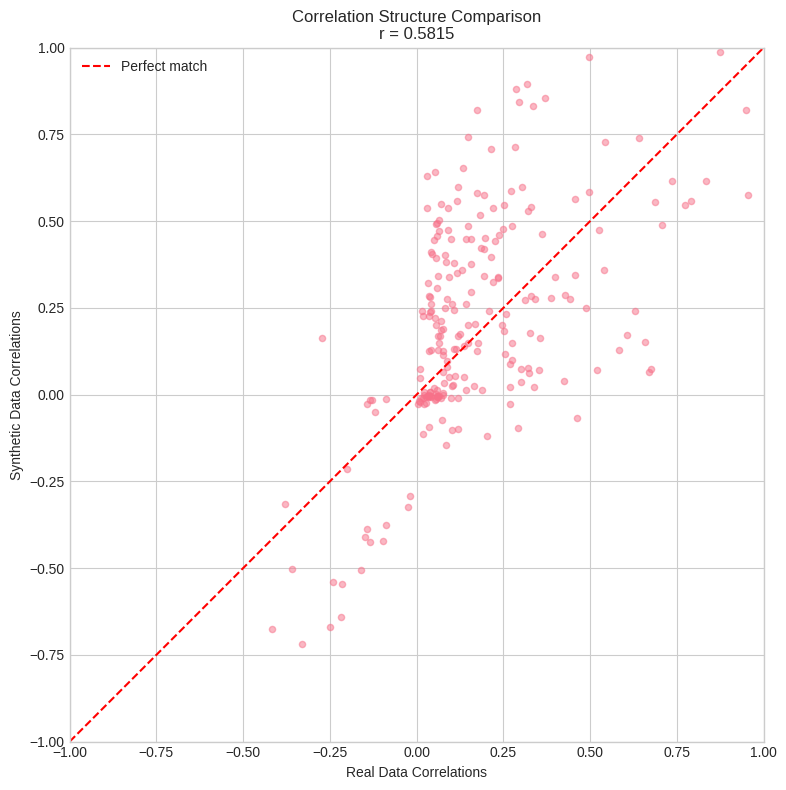

Saved: /home/smotaali/BGP_Traffic_Generation/results/05_correlation_scatter.png


In [17]:
# Scatter plot of correlations
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(corr_real_flat, corr_syn_flat, alpha=0.5, s=20)
ax.plot([-1, 1], [-1, 1], 'r--', label='Perfect match')
ax.set_xlabel('Real Data Correlations')
ax.set_ylabel('Synthetic Data Correlations')
ax.set_title(f'Correlation Structure Comparison\nr = {structure_corr:.4f}')
ax.legend()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05_correlation_scatter_20251214_182312.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/05_correlation_scatter.png")

SPEARMAN CORRELATION ANALYSIS
Mean absolute correlation difference (Spearman): 0.1997
Max absolute correlation difference (Spearman): 0.7859

[Comparison]
Mean absolute correlation difference (Pearson):  0.1975
Max absolute correlation difference (Pearson):   0.6475

CORRELATION STRUCTURE SIMILARITY
Spearman: r = 0.5684, p-value = 3.64e-21
Pearson:  r = 0.5815, p-value = 2.71e-22

Improvement: -2.3% decrease

Spearman Interpretation: Moderate structural similarity
Pearson Interpretation:  Moderate structural similarity


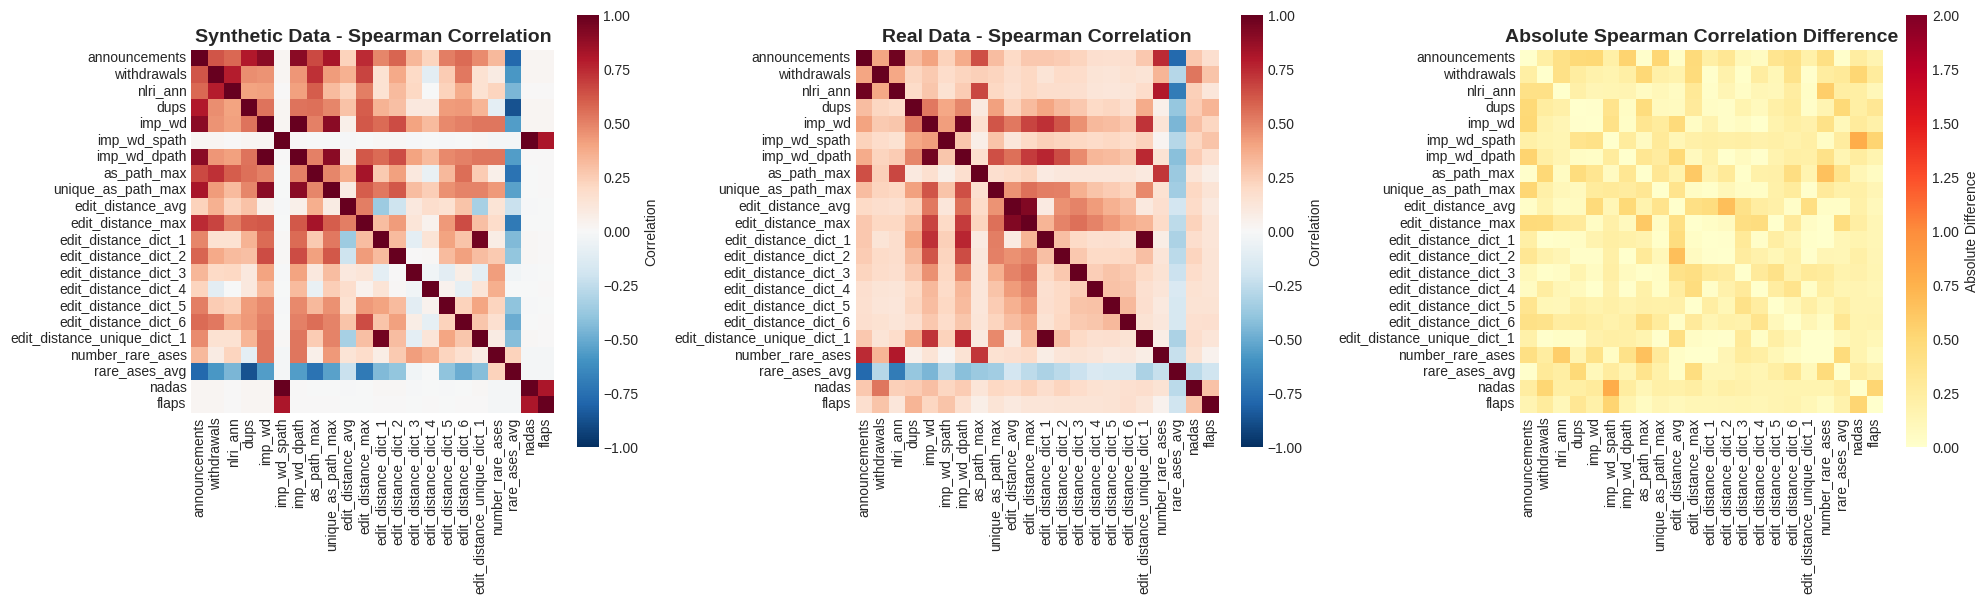


Saved: /home/smotaali/BGP_Traffic_Generation/results/04b_correlation_comparison_spearman.png


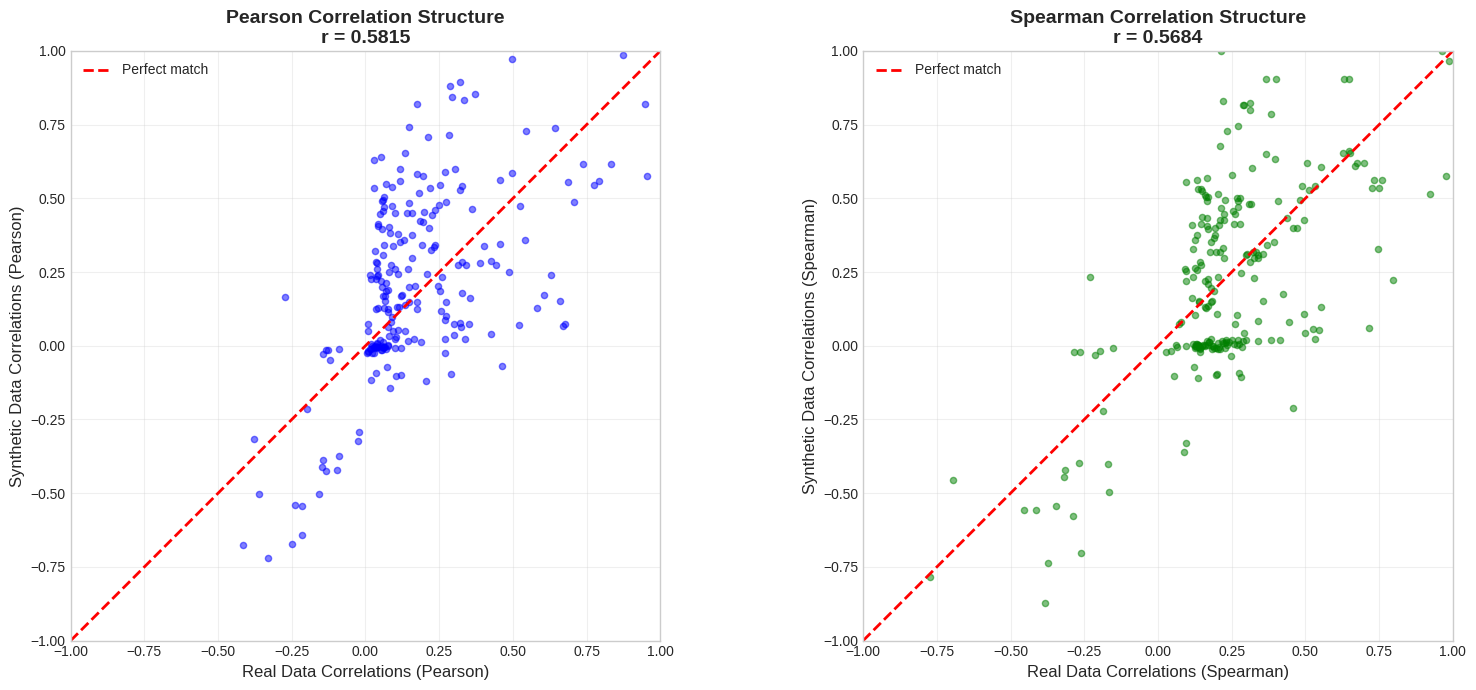

Saved: /home/smotaali/BGP_Traffic_Generation/results/05b_correlation_scatter_comparison.png

PEARSON vs SPEARMAN COMPARISON TABLE
                        Metric  Pearson Spearman
Mean Absolute Correlation Diff   0.1975   0.1997
 Max Absolute Correlation Diff   0.6475   0.7859
     Structure Correlation (r)   0.5815   0.5684
             Structure P-value 2.71e-22 3.64e-21
                Interpretation Moderate Moderate

Saved comparison table to: /home/smotaali/BGP_Traffic_Generation/results/phase1_pearson_vs_spearman.csv


In [18]:
# ============================================================================
# SPEARMAN CORRELATION ANALYSIS (Comparison with Pearson)
# ============================================================================

# Calculate Spearman correlations (more robust for non-linear relationships)
corr_synthetic_spearman = df_syn_clean.corr(method='spearman')
corr_real_spearman = df_real_clean.corr(method='spearman')

# Calculate differences
corr_diff_spearman = abs(corr_synthetic_spearman - corr_real_spearman)

print("=" * 80)
print("SPEARMAN CORRELATION ANALYSIS")
print("=" * 80)
print(f"Mean absolute correlation difference (Spearman): {corr_diff_spearman.values.mean():.4f}")
print(f"Max absolute correlation difference (Spearman): {corr_diff_spearman.values.max():.4f}")

# For comparison, show Pearson stats again
print(f"\n[Comparison]")
print(f"Mean absolute correlation difference (Pearson):  {corr_diff.values.mean():.4f}")
print(f"Max absolute correlation difference (Pearson):   {corr_diff.values.max():.4f}")

# Correlation Structure Similarity (Spearman)
corr_syn_flat_spearman = get_upper_triangle(corr_synthetic_spearman)
corr_real_flat_spearman = get_upper_triangle(corr_real_spearman)

# Calculate Spearman correlation of correlation structures
structure_corr_spearman, structure_p_spearman = stats.spearmanr(corr_syn_flat_spearman, corr_real_flat_spearman)

print(f"\n" + "=" * 80)
print("CORRELATION STRUCTURE SIMILARITY")
print("=" * 80)
print(f"Spearman: r = {structure_corr_spearman:.4f}, p-value = {structure_p_spearman:.2e}")
print(f"Pearson:  r = {structure_corr:.4f}, p-value = {structure_p:.2e}")
print(f"\nImprovement: {((structure_corr_spearman - structure_corr) / abs(structure_corr) * 100):.1f}% {'increase' if structure_corr_spearman > structure_corr else 'decrease'}")

# Interpretation
def interpret_similarity(r):
    if r > 0.8:
        return "High"
    elif r > 0.5:
        return "Moderate"
    elif r > 0.3:
        return "Low-Moderate"
    else:
        return "Low"

print(f"\nSpearman Interpretation: {interpret_similarity(structure_corr_spearman)} structural similarity")
print(f"Pearson Interpretation:  {interpret_similarity(structure_corr)} structural similarity")

# Visualize Spearman correlation matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Synthetic Spearman correlation
sns.heatmap(corr_synthetic_spearman, ax=axes[0], cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, square=True, cbar_kws={'label': 'Correlation'})
axes[0].set_title('Synthetic Data - Spearman Correlation', fontsize=14, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Real Spearman correlation
sns.heatmap(corr_real_spearman, ax=axes[1], cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, square=True, cbar_kws={'label': 'Correlation'})
axes[1].set_title('Real Data - Spearman Correlation', fontsize=14, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Absolute difference
sns.heatmap(corr_diff_spearman, ax=axes[2], cmap='YlOrRd', 
            vmin=0, vmax=2, square=True, cbar_kws={'label': 'Absolute Difference'})
axes[2].set_title('Absolute Spearman Correlation Difference', fontsize=14, fontweight='bold')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/04b_correlation_comparison_spearman_{TIMESTAMP}.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nSaved: {OUTPUT_DIR}/04b_correlation_comparison_spearman.png")

# Scatter plot comparing Spearman correlation structures
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Pearson scatter
axes[0].scatter(corr_real_flat, corr_syn_flat, alpha=0.5, s=20, c='blue')
axes[0].plot([-1, 1], [-1, 1], 'r--', linewidth=2, label='Perfect match')
axes[0].set_xlabel('Real Data Correlations (Pearson)', fontsize=12)
axes[0].set_ylabel('Synthetic Data Correlations (Pearson)', fontsize=12)
axes[0].set_title(f'Pearson Correlation Structure\nr = {structure_corr:.4f}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(-1, 1)
axes[0].set_ylim(-1, 1)
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Spearman scatter
axes[1].scatter(corr_real_flat_spearman, corr_syn_flat_spearman, alpha=0.5, s=20, c='green')
axes[1].plot([-1, 1], [-1, 1], 'r--', linewidth=2, label='Perfect match')
axes[1].set_xlabel('Real Data Correlations (Spearman)', fontsize=12)
axes[1].set_ylabel('Synthetic Data Correlations (Spearman)', fontsize=12)
axes[1].set_title(f'Spearman Correlation Structure\nr = {structure_corr_spearman:.4f}', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_xlim(-1, 1)
axes[1].set_ylim(-1, 1)
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05b_correlation_scatter_comparison_{TIMESTAMP}.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/05b_correlation_scatter_comparison.png")

# Summary comparison table
comparison_df = pd.DataFrame({
    'Metric': [
        'Mean Absolute Correlation Diff',
        'Max Absolute Correlation Diff',
        'Structure Correlation (r)',
        'Structure P-value',
        'Interpretation'
    ],
    'Pearson': [
        f"{corr_diff.values.mean():.4f}",
        f"{corr_diff.values.max():.4f}",
        f"{structure_corr:.4f}",
        f"{structure_p:.2e}",
        interpret_similarity(structure_corr)
    ],
    'Spearman': [
        f"{corr_diff_spearman.values.mean():.4f}",
        f"{corr_diff_spearman.values.max():.4f}",
        f"{structure_corr_spearman:.4f}",
        f"{structure_p_spearman:.2e}",
        interpret_similarity(structure_corr_spearman)
    ]
})

print("\n" + "=" * 80)
print("PEARSON vs SPEARMAN COMPARISON TABLE")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv(f'{OUTPUT_DIR}/phase1_pearson_vs_spearman_{TIMESTAMP}.csv', index=False)
print(f"\nSaved comparison table to: {OUTPUT_DIR}/phase1_pearson_vs_spearman.csv")


📊 Found 53 significant dependencies in REAL data (Pearson, |r| > 0.3)
📊 Found 74 significant dependencies in REAL data (Spearman, |r| > 0.3)

REAL DATA DEPENDENCIES (Pearson) - Top 20 Strongest
            feature1                    feature2  correlation  abs_correlation relationship    strength  method
       announcements                    nlri_ann     0.954746         0.954746     Positive Very Strong Pearson
edit_distance_dict_1 edit_distance_unique_dict_1     0.949581         0.949581     Positive Very Strong Pearson
              imp_wd                imp_wd_dpath     0.873618         0.873618     Positive Very Strong Pearson
        imp_wd_dpath        edit_distance_dict_1     0.833813         0.833813     Positive Very Strong Pearson
        imp_wd_dpath edit_distance_unique_dict_1     0.792201         0.792201     Positive      Strong Pearson
   edit_distance_avg           edit_distance_max     0.774268         0.774268     Positive      Strong Pearson
              imp_wd 

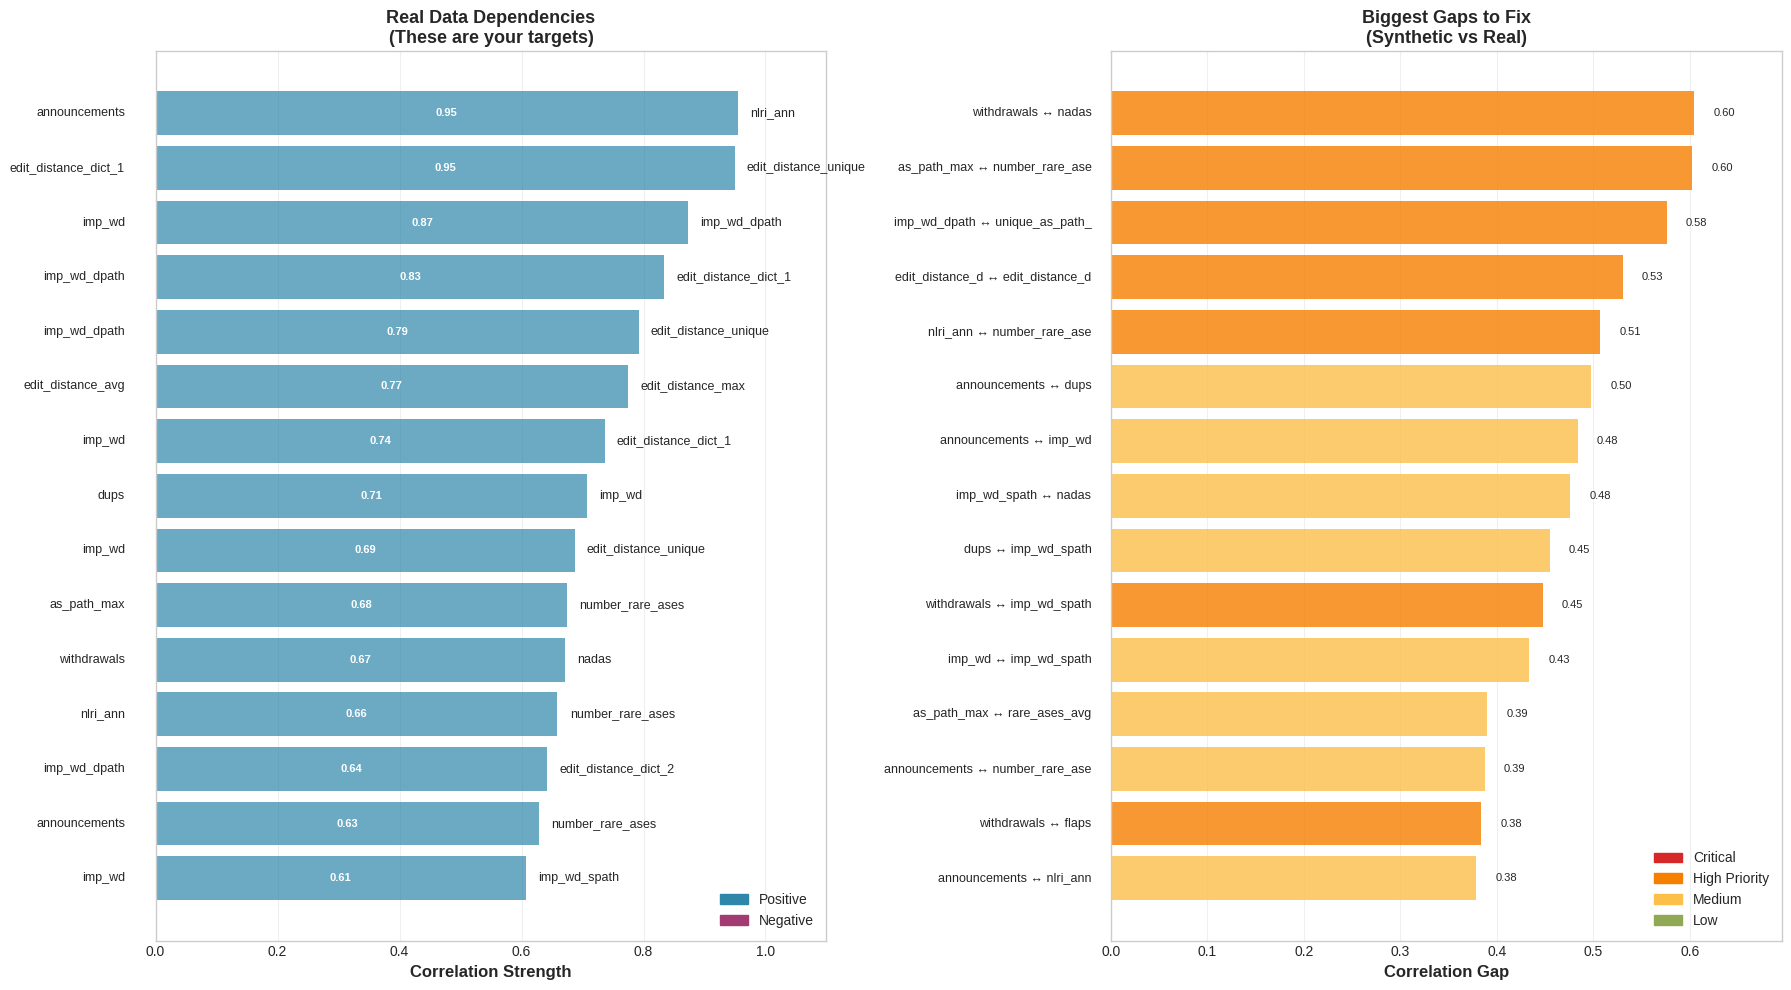

✅ Saved visualization: /home/smotaali/BGP_Traffic_Generation/results/dependency_analysis.png

✅ ANALYSIS COMPLETE!


In [19]:
# ============================================================================
# DEPENDENCY LEARNING FROM REAL DATA & SYNTHETIC GAP ANALYSIS
# ============================================================================

import pandas as pd
import numpy as np
from scipy import stats


corr_real_common = df_real_clean.corr(method='pearson')
corr_synthetic_common = df_syn_clean.corr(method='pearson')
corr_real_spearman_common = df_real_clean.corr(method='spearman')
corr_synthetic_spearman_common = df_syn_clean.corr(method='spearman')


# Function to extract important correlations from real data
def extract_real_dependencies(corr_matrix, threshold=0.3, method_name='Pearson'):
    """
    Extract significant correlations from real data
    
    Args:
        corr_matrix: Correlation matrix from real data
        threshold: Minimum |correlation| to consider significant
        method_name: 'Pearson' or 'Spearman'
    
    Returns:
        DataFrame with significant correlations
    """
    dependencies = []
    features = corr_matrix.columns.tolist()
    
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            corr_value = corr_matrix.iloc[i, j]
            
            if abs(corr_value) >= threshold:
                dependencies.append({
                    'feature1': features[i],
                    'feature2': features[j],
                    'correlation': corr_value,
                    'abs_correlation': abs(corr_value),
                    'relationship': 'Positive' if corr_value > 0 else 'Negative',
                    'strength': 'Very Strong' if abs(corr_value) > 0.8 else 
                               'Strong' if abs(corr_value) > 0.6 else 
                               'Moderate' if abs(corr_value) > 0.4 else 'Weak',
                    'method': method_name
                })
    
    return pd.DataFrame(dependencies).sort_values('abs_correlation', ascending=False)

# Extract dependencies from real data (Pearson)
real_deps_pearson = extract_real_dependencies(
    corr_real_common, 
    threshold=0.3, 
    method_name='Pearson'
)

# Extract dependencies from real data (Spearman)
real_deps_spearman = extract_real_dependencies(
    corr_real_spearman_common, 
    threshold=0.3, 
    method_name='Spearman'
)

print(f"\n📊 Found {len(real_deps_pearson)} significant dependencies in REAL data (Pearson, |r| > 0.3)")
print(f"📊 Found {len(real_deps_spearman)} significant dependencies in REAL data (Spearman, |r| > 0.3)")

print("\n" + "=" * 100)
print("REAL DATA DEPENDENCIES (Pearson) - Top 20 Strongest")
print("=" * 100)
print(real_deps_pearson.head(20).to_string(index=False))

# ============================================================================
# STEP 2: COMPARE WITH SYNTHETIC DATA - FIND THE GAPS
# ============================================================================

print("\n" + "=" * 100)
print("STEP 2: GAP ANALYSIS - COMPARING REAL vs SYNTHETIC DEPENDENCIES")
print("=" * 100)

def analyze_dependency_gaps(real_deps, corr_synthetic, corr_real, method_name='Pearson'):
    """
    For each real dependency, check if it exists in synthetic data
    
    Args:
        real_deps: DataFrame of real data dependencies
        corr_synthetic: Synthetic correlation matrix
        corr_real: Real correlation matrix
        method_name: 'Pearson' or 'Spearman'
    
    Returns:
        DataFrame with gap analysis
    """
    gaps = []
    
    for idx, row in real_deps.iterrows():
        f1, f2 = row['feature1'], row['feature2']
        real_corr = row['correlation']
        
        # Get synthetic correlation
        try:
            syn_corr = corr_synthetic.loc[f1, f2]
        except:
            syn_corr = np.nan
        
        gap = abs(real_corr - syn_corr) if not np.isnan(syn_corr) else abs(real_corr)
        
        # Determine status
        if np.isnan(syn_corr):
            status = '❌ MISSING'
            priority = 'CRITICAL'
        elif abs(syn_corr) < 0.1:
            status = '❌ ABSENT (< 0.1)'
            priority = 'HIGH'
        elif gap > 0.5:
            status = '🔴 MAJOR GAP'
            priority = 'HIGH'
        elif gap > 0.3:
            status = '🟠 MODERATE GAP'
            priority = 'MEDIUM'
        elif gap > 0.15:
            status = '🟡 SMALL GAP'
            priority = 'LOW'
        else:
            status = '✅ GOOD'
            priority = 'NONE'
        
        # Check if sign is wrong
        sign_match = (real_corr > 0) == (syn_corr > 0) if not np.isnan(syn_corr) else True
        
        gaps.append({
            'feature1': f1,
            'feature2': f2,
            'real_correlation': real_corr,
            'synthetic_correlation': syn_corr,
            'gap': gap,
            'status': status,
            'priority': priority,
            'sign_correct': sign_match,
            'real_strength': row['strength'],
            'method': method_name
        })
    
    return pd.DataFrame(gaps).sort_values('gap', ascending=False)

# Analyze gaps for Pearson
gaps_pearson = analyze_dependency_gaps(
    real_deps_pearson, 
    corr_synthetic_common, 
    corr_real_common,
    method_name='Pearson'
)

# Analyze gaps for Spearman
gaps_spearman = analyze_dependency_gaps(
    real_deps_spearman, 
    corr_real_spearman_common,
    corr_synthetic_spearman_common,
    method_name='Spearman'
)

print("\n📋 GAP ANALYSIS SUMMARY (Pearson):")
print(f"  ✅ Good matches (gap < 0.15): {(gaps_pearson['priority'] == 'NONE').sum()}")
print(f"  🟡 Small gaps (0.15-0.3): {(gaps_pearson['priority'] == 'LOW').sum()}")
print(f"  🟠 Moderate gaps (0.3-0.5): {(gaps_pearson['priority'] == 'MEDIUM').sum()}")
print(f"  🔴 Major gaps (> 0.5): {(gaps_pearson['priority'] == 'HIGH').sum()}")
print(f"  ❌ Critical (missing): {(gaps_pearson['priority'] == 'CRITICAL').sum()}")

# ============================================================================
# STEP 3: PRIORITIZED ACTION PLAN
# ============================================================================

print("\n" + "=" * 100)
print("STEP 3: PRIORITIZED DEPENDENCIES TO FIX IN SYNTHETIC GENERATOR")
print("=" * 100)

# Filter for actionable items (HIGH and CRITICAL priority)
actionable = gaps_pearson[gaps_pearson['priority'].isin(['HIGH', 'CRITICAL'])].copy()

print(f"\n🎯 {len(actionable)} HIGH PRIORITY dependencies to fix:\n")
print(actionable[['feature1', 'feature2', 'real_correlation', 'synthetic_correlation', 
                   'gap', 'status', 'real_strength']].to_string(index=False))


# ============================================================================
# STEP 5: SAVE RESULTS
# ============================================================================

# Save gap analysis
gaps_pearson.to_csv(f'{OUTPUT_DIR}/dependency_gaps_pearson_20251214_182312.csv', index=False)
gaps_spearman.to_csv(f'{OUTPUT_DIR}/dependency_gaps_spearman_20251214_182312.csv', index=False)

# Save real dependencies
real_deps_pearson.to_csv(f'{OUTPUT_DIR}/real_dependencies_pearson_20251214_182312.csv', index=False)
real_deps_spearman.to_csv(f'{OUTPUT_DIR}/real_dependencies_spearman_20251214_182312.csv', index=False)

# Save actionable priorities
actionable.to_csv(f'{OUTPUT_DIR}/priority_fixes_20251213_185355.csv', index=False)

print("\n" + "=" * 100)
print("FILES SAVED")
print("=" * 100)
print(f"✅ Real dependencies (Pearson): {OUTPUT_DIR}/real_dependencies_pearson.csv")
print(f"✅ Real dependencies (Spearman): {OUTPUT_DIR}/real_dependencies_spearman.csv")
print(f"✅ Gap analysis (Pearson): {OUTPUT_DIR}/dependency_gaps_pearson.csv")
print(f"✅ Gap analysis (Spearman): {OUTPUT_DIR}/dependency_gaps_spearman.csv")
print(f"✅ Priority fixes: {OUTPUT_DIR}/priority_fixes.csv")

# ============================================================================
# STEP 6: VISUALIZATION OF DEPENDENCY NETWORK
# ============================================================================

print("\n" + "=" * 100)
print("STEP 6: VISUALIZING DEPENDENCY NETWORK")
print("=" * 100)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create network visualization for top dependencies
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Left plot: Real dependencies
ax1 = axes[0]
top_real = real_deps_pearson.head(15)

for i, (idx, row) in enumerate(top_real.iterrows()):
    y_pos = len(top_real) - i - 1
    color = '#2E86AB' if row['relationship'] == 'Positive' else '#A23B72'
    ax1.barh(y_pos, row['abs_correlation'], color=color, alpha=0.7)
    ax1.text(-0.05, y_pos, f"{row['feature1'][:20]}", ha='right', va='center', fontsize=9)
    ax1.text(row['abs_correlation'] + 0.02, y_pos, f"{row['feature2'][:20]}", ha='left', va='center', fontsize=9)
    ax1.text(row['abs_correlation']/2, y_pos, f"{row['correlation']:.2f}", 
             ha='center', va='center', fontsize=8, fontweight='bold', color='white')

ax1.set_xlabel('Correlation Strength', fontsize=12, fontweight='bold')
ax1.set_title('Real Data Dependencies\n(These are your targets)', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 1.1)
ax1.set_yticks([])
ax1.grid(axis='x', alpha=0.3)

# Legend
pos_patch = mpatches.Patch(color='#2E86AB', label='Positive')
neg_patch = mpatches.Patch(color='#A23B72', label='Negative')
ax1.legend(handles=[pos_patch, neg_patch], loc='lower right')

# Right plot: Gap sizes
ax2 = axes[1]
top_gaps = gaps_pearson.head(15)

colors_gap = []
for _, row in top_gaps.iterrows():
    if row['priority'] == 'CRITICAL':
        colors_gap.append('#D62828')  # Red
    elif row['priority'] == 'HIGH':
        colors_gap.append('#F77F00')  # Orange
    elif row['priority'] == 'MEDIUM':
        colors_gap.append('#FCBF49')  # Yellow
    else:
        colors_gap.append('#90A955')  # Green

for i, (idx, row) in enumerate(top_gaps.iterrows()):
    y_pos = len(top_gaps) - i - 1
    ax2.barh(y_pos, row['gap'], color=colors_gap[i], alpha=0.8)
    
    label = f"{row['feature1'][:15]} ↔ {row['feature2'][:15]}"
    ax2.text(-0.02, y_pos, label, ha='right', va='center', fontsize=9)
    ax2.text(row['gap'] + 0.02, y_pos, f"{row['gap']:.2f}", ha='left', va='center', fontsize=8)

ax2.set_xlabel('Correlation Gap', fontsize=12, fontweight='bold')
ax2.set_title('Biggest Gaps to Fix\n(Synthetic vs Real)', fontsize=13, fontweight='bold')
ax2.set_xlim(0, max(top_gaps['gap']) * 1.15)
ax2.set_yticks([])
ax2.grid(axis='x', alpha=0.3)

# Legend
crit_patch = mpatches.Patch(color='#D62828', label='Critical')
high_patch = mpatches.Patch(color='#F77F00', label='High Priority')
med_patch = mpatches.Patch(color='#FCBF49', label='Medium')
low_patch = mpatches.Patch(color='#90A955', label='Low')
ax2.legend(handles=[crit_patch, high_patch, med_patch, low_patch], loc='lower right')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/dependency_analysis_20251213_185355.png', dpi=200, bbox_inches='tight')
plt.show()
print(f"✅ Saved visualization: {OUTPUT_DIR}/dependency_analysis.png")

print("\n" + "=" * 100)
print("✅ ANALYSIS COMPLETE!")
print("=" * 100)


## 6. Dimensionality Reduction (PCA & t-SNE)

In [20]:
# Combine and scale data
X_combined = np.vstack([X_synthetic, X_real])
labels = ['Synthetic'] * len(X_synthetic) + ['Real'] * len(X_real)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

print(f"Combined data shape: {X_combined.shape}")

Combined data shape: (40930, 27)


In [21]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

PCA explained variance ratio: [0.19950188 0.15272404]
Total variance explained: 35.22%


In [22]:
# t-SNE (use subset for speed)
n_tsne_samples = min(5000, len(X_scaled))
np.random.seed(RANDOM_SEED)
tsne_idx = np.random.choice(len(X_scaled), n_tsne_samples, replace=False)

tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled[tsne_idx])
labels_tsne = [labels[i] for i in tsne_idx]

print(f"t-SNE completed on {n_tsne_samples} samples")

t-SNE completed on 5000 samples


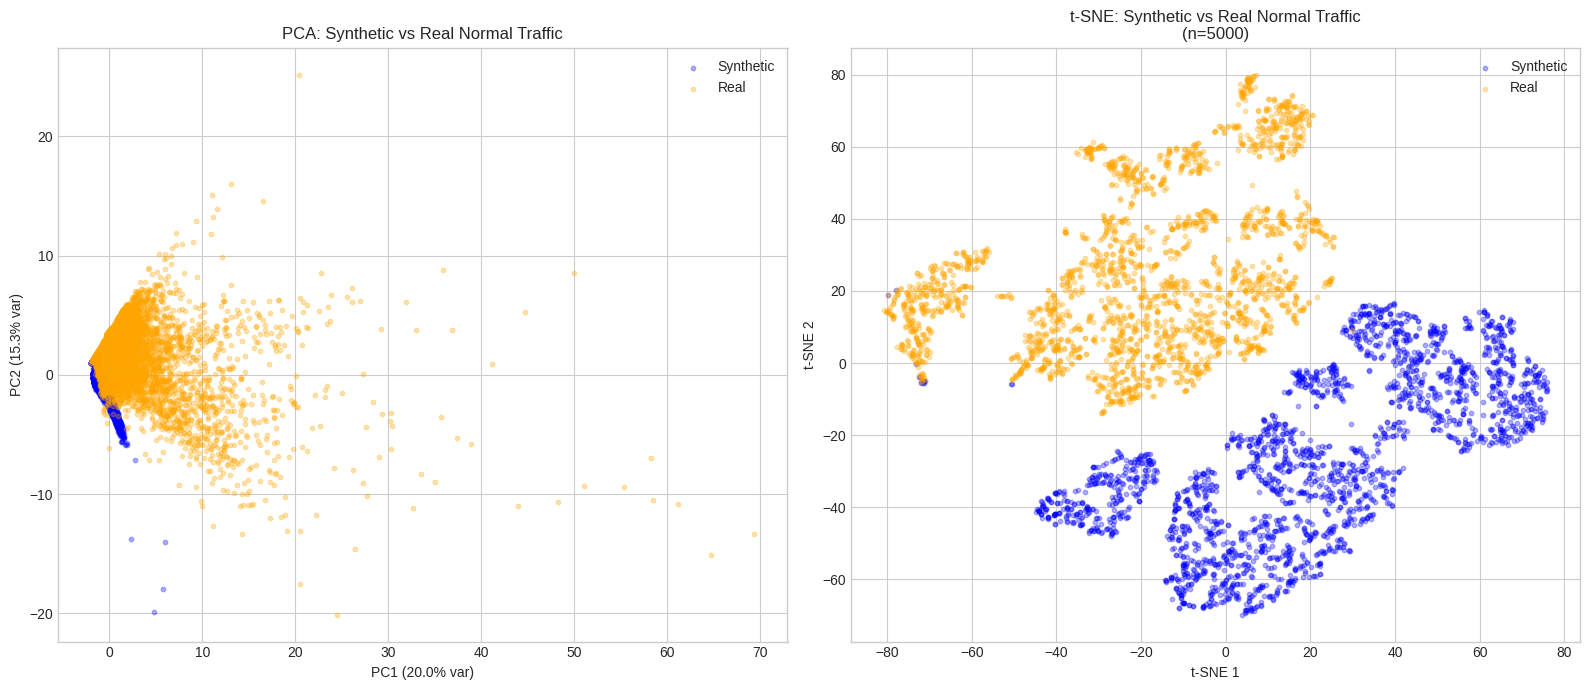

Saved: /home/smotaali/BGP_Traffic_Generation/results/06_dimensionality_reduction.png


In [23]:
# Plot PCA and t-SNE
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA plot
colors = {'Synthetic': 'blue', 'Real': 'orange'}
for label in ['Synthetic', 'Real']:
    mask = np.array(labels) == label
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                    c=colors[label], label=label, alpha=0.3, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[0].set_title('PCA: Synthetic vs Real Normal Traffic')
axes[0].legend()

# t-SNE plot
for label in ['Synthetic', 'Real']:
    mask = np.array(labels_tsne) == label
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                    c=colors[label], label=label, alpha=0.3, s=10)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title(f't-SNE: Synthetic vs Real Normal Traffic\n(n={n_tsne_samples})')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/06_dimensionality_reduction_20251214_182312.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/06_dimensionality_reduction.png")

Components needed for 95% variance: 16


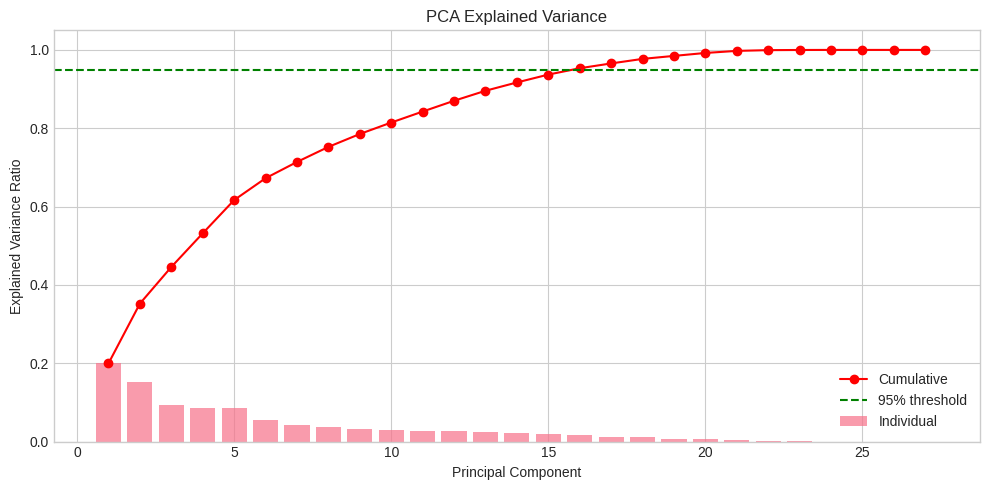

Saved: /home/smotaali/BGP_Traffic_Generation/results/07_pca_variance.png


In [24]:
# PCA with more components to see variance explained
pca_full = PCA(n_components=min(27, len(feature_cols)))
pca_full.fit(X_scaled)

fig, ax = plt.subplots(figsize=(10, 5))

cumvar = np.cumsum(pca_full.explained_variance_ratio_)
ax.bar(range(1, len(cumvar)+1), pca_full.explained_variance_ratio_, alpha=0.7, label='Individual')
ax.plot(range(1, len(cumvar)+1), cumvar, 'ro-', label='Cumulative')
ax.axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('PCA Explained Variance')
ax.legend()

n_components_95 = np.argmax(cumvar >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components_95}")

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/07_pca_variance_20251214_182312.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/07_pca_variance.png")

## 7. Additional Statistical Tests

In [25]:
# Mann-Whitney U test (non-parametric alternative to t-test)
mw_results = []

for col in feature_cols:
    stat, p_value = stats.mannwhitneyu(df_synthetic[col], df_real[col], alternative='two-sided')
    mw_results.append({
        'feature': col,
        'mw_statistic': stat,
        'p_value': p_value,
        'similar': p_value > ALPHA
    })

mw_df = pd.DataFrame(mw_results)
mw_df = mw_df.sort_values('p_value', ascending=True)
mw_df.to_csv(f'{OUTPUT_DIR}/phase1_mw_df_20251214_182312.csv')

print("Mann-Whitney U Test Results")
print("=" * 60)
print(f"Features with similar medians: {mw_df['similar'].sum()}/{len(feature_cols)}")
print("\n")
print(mw_df.to_string(index=False))

Mann-Whitney U Test Results
Features with similar medians: 4/27


                    feature  mw_statistic       p_value  similar
              announcements    55955089.5  0.000000e+00    False
              rare_ases_avg   367699602.5  0.000000e+00    False
           number_rare_ases   111058192.0  0.000000e+00    False
edit_distance_unique_dict_1   147390156.5  0.000000e+00    False
       edit_distance_dict_6   261615373.0  0.000000e+00    False
       edit_distance_dict_5   272900819.5  0.000000e+00    False
       edit_distance_dict_4   311290185.5  0.000000e+00    False
       edit_distance_dict_3   339128377.0  0.000000e+00    False
       edit_distance_dict_2   257279318.0  0.000000e+00    False
       edit_distance_dict_1   161180317.5  0.000000e+00    False
                      nadas   129496165.0  0.000000e+00    False
          edit_distance_avg   360832351.0  0.000000e+00    False
          edit_distance_max   343475523.0  0.000000e+00    False
                as_path_

In [26]:
# Cohen's d effect size for each feature
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (group1.mean() - group2.mean()) / pooled_std if pooled_std > 0 else 0

effect_sizes = []
for col in feature_cols:
    d = cohens_d(df_synthetic[col], df_real[col])
    # Interpret effect size
    if abs(d) < 0.2:
        interpretation = 'Negligible'
    elif abs(d) < 0.5:
        interpretation = 'Small'
    elif abs(d) < 0.8:
        interpretation = 'Medium'
    else:
        interpretation = 'Large'
    
    effect_sizes.append({
        'feature': col,
        'cohens_d': d,
        'abs_d': abs(d),
        'interpretation': interpretation
    })

effect_df = pd.DataFrame(effect_sizes).sort_values('abs_d', ascending=False)
effect_df.to_csv(f'{OUTPUT_DIR}/phase1_effect_df_20251214_182312.csv')

print("Cohen's d Effect Size Analysis")
print("=" * 60)
print(f"\nEffect Size Distribution:")
print(effect_df['interpretation'].value_counts())
print("\n")
print(effect_df.to_string(index=False))

Cohen's d Effect Size Analysis

Effect Size Distribution:
interpretation
Small         10
Negligible     8
Large          7
Medium         2
Name: count, dtype: int64


                    feature  cohens_d    abs_d interpretation
                   origin_0  2.592180 2.592180          Large
                as_path_max -1.507600 1.507600          Large
              rare_ases_avg  1.439691 1.439691          Large
          edit_distance_avg  1.320566 1.320566          Large
         unique_as_path_max  1.040221 1.040221          Large
          edit_distance_max  0.987203 0.987203          Large
           number_rare_ases -0.938269 0.938269          Large
              announcements -0.792175 0.792175         Medium
                   nlri_ann -0.786653 0.786653         Medium
       edit_distance_dict_4  0.401241 0.401241          Small
       edit_distance_dict_3  0.326170 0.326170          Small
                withdrawals -0.320702 0.320702          Small
       edit_distance_dict

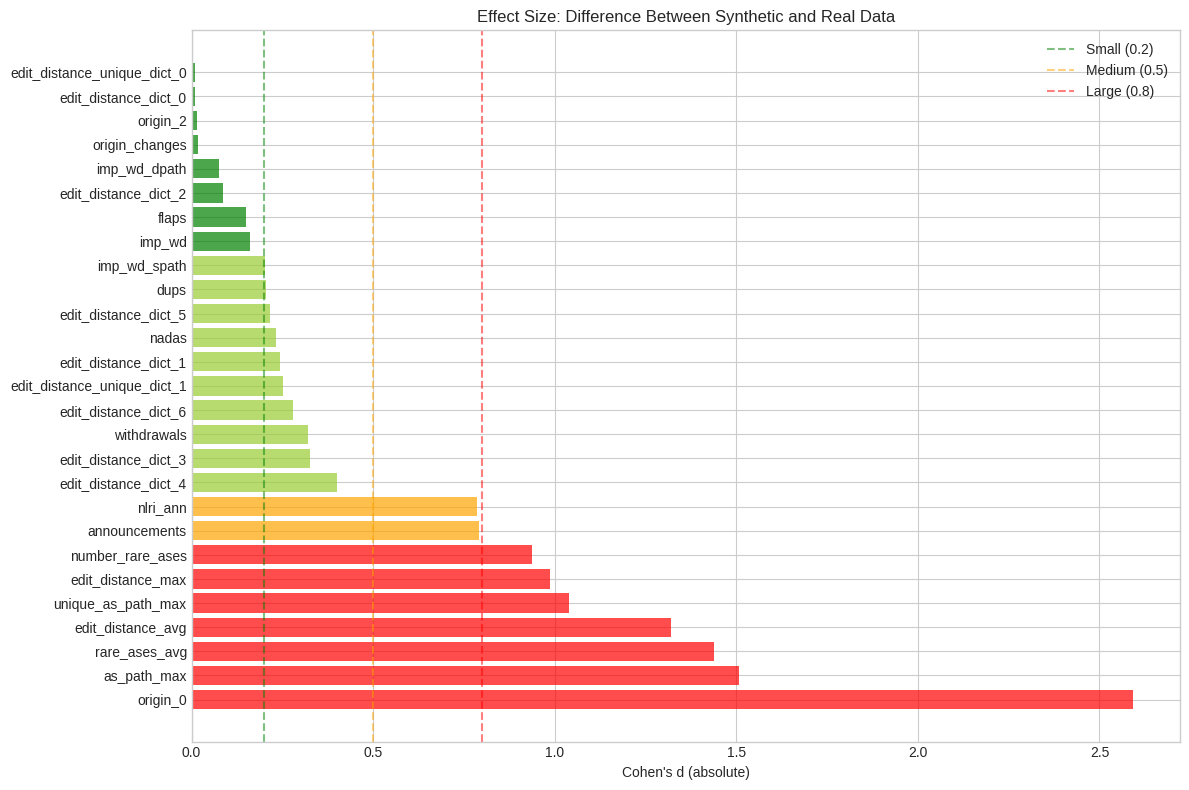

Saved: /home/smotaali/BGP_Traffic_Generation/results/08_effect_sizes.png


In [27]:
# Visualize effect sizes
fig, ax = plt.subplots(figsize=(12, 8))

colors_effect = {
    'Negligible': 'green',
    'Small': 'yellowgreen', 
    'Medium': 'orange',
    'Large': 'red'
}
bar_colors = [colors_effect[interp] for interp in effect_df['interpretation']]

ax.barh(effect_df['feature'], effect_df['abs_d'], color=bar_colors, alpha=0.7)
ax.axvline(x=0.2, color='green', linestyle='--', alpha=0.5, label='Small (0.2)')
ax.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Medium (0.5)')
ax.axvline(x=0.8, color='red', linestyle='--', alpha=0.5, label='Large (0.8)')
ax.set_xlabel("Cohen's d (absolute)")
ax.set_title("Effect Size: Difference Between Synthetic and Real Data")
ax.legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/08_effect_sizes_20251214_182312.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/08_effect_sizes.png")

## 8. Summary Report

In [28]:
# Generate comprehensive summary
print("=" * 80)
print("PHASE 1: NORMAL TRAFFIC VALIDATION - SUMMARY REPORT")
print("=" * 80)

print(f"\n📊 DATA OVERVIEW")
print(f"   Synthetic normal samples: {len(synthetic_sampled):,}")
print(f"   Real normal samples: {len(real_sampled):,}")
print(f"   Features compared: {len(feature_cols)}")

print(f"\n📈 DISTRIBUTION SIMILARITY (KS-Test, α={ALPHA})")
ks_similar = ks_df['similar_distribution'].sum()
ks_pct = ks_similar / len(feature_cols) * 100
print(f"   Similar distributions: {ks_similar}/{len(feature_cols)} ({ks_pct:.1f}%)")
print(f"   Mean KS statistic: {ks_df['ks_statistic'].mean():.4f}")

print(f"\n🔗 CORRELATION STRUCTURE")
print(f"   Correlation similarity (Pearson r): {structure_corr:.4f}")
print(f"   Mean correlation difference: {corr_diff.values.mean():.4f}")

print(f"\n📏 EFFECT SIZES (Cohen's d)")
effect_counts = effect_df['interpretation'].value_counts()
for interp in ['Negligible', 'Small', 'Medium', 'Large']:
    count = effect_counts.get(interp, 0)
    print(f"   {interp}: {count} features")

print(f"\n🎯 OVERALL ASSESSMENT")
# Calculate overall similarity score
ks_score = ks_pct / 100
corr_score = structure_corr
effect_score = (effect_counts.get('Negligible', 0) + effect_counts.get('Small', 0) * 0.5) / len(feature_cols)
overall_score = (ks_score + corr_score + effect_score) / 3 * 100

print(f"   Distribution Score: {ks_score*100:.1f}/100")
print(f"   Correlation Score: {corr_score*100:.1f}/100")
print(f"   Effect Size Score: {effect_score*100:.1f}/100")
print(f"   ───────────────────────")
print(f"   OVERALL SIMILARITY: {overall_score:.1f}/100")

if overall_score >= 70:
    verdict = "✅ GOOD - Synthetic data reasonably represents real traffic"
elif overall_score >= 50:
    verdict = "⚠️ MODERATE - Some features need improvement"
else:
    verdict = "❌ POOR - Significant differences detected"
print(f"\n   Verdict: {verdict}")

print(f"\n📋 FEATURES NEEDING ATTENTION (Large effect size):")
large_effect = effect_df[effect_df['interpretation'] == 'Large']['feature'].tolist()
if large_effect:
    for f in large_effect:
        print(f"   • {f}")
else:
    print("   None - all features have acceptable effect sizes")

print("\n" + "=" * 80)

PHASE 1: NORMAL TRAFFIC VALIDATION - SUMMARY REPORT

📊 DATA OVERVIEW
   Synthetic normal samples: 20,465
   Real normal samples: 20,465
   Features compared: 27

📈 DISTRIBUTION SIMILARITY (KS-Test, α=0.05)
   Similar distributions: 4/27 (14.8%)
   Mean KS statistic: 0.3795

🔗 CORRELATION STRUCTURE
   Correlation similarity (Pearson r): 0.5815
   Mean correlation difference: 0.1975

📏 EFFECT SIZES (Cohen's d)
   Negligible: 8 features
   Small: 10 features
   Medium: 2 features
   Large: 7 features

🎯 OVERALL ASSESSMENT
   Distribution Score: 14.8/100
   Correlation Score: 58.1/100
   Effect Size Score: 48.1/100
   ───────────────────────
   OVERALL SIMILARITY: 40.4/100

   Verdict: ❌ POOR - Significant differences detected

📋 FEATURES NEEDING ATTENTION (Large effect size):
   • origin_0
   • as_path_max
   • rare_ases_avg
   • edit_distance_avg
   • unique_as_path_max
   • edit_distance_max
   • number_rare_ases



In [29]:
# Save detailed results to CSV
# Merge all test results
results_df = ks_df.merge(mw_df[['feature', 'mw_statistic', 'p_value']], 
                          on='feature', suffixes=('_ks', '_mw'))
results_df = results_df.merge(effect_df[['feature', 'cohens_d', 'interpretation']], on='feature')
results_df = results_df.merge(mean_diff.reset_index().rename(columns={'index': 'feature'}), on='feature')

results_df.to_csv(f'{OUTPUT_DIR}/phase1_detailed_results_20251214_182312.csv', index=False)
print(f"Detailed results saved to: {OUTPUT_DIR}/phase1_detailed_results.csv")

# Display final table
print("\nFinal Results Table:")
results_df

Detailed results saved to: /home/smotaali/BGP_Traffic_Generation/results/phase1_detailed_results.csv

Final Results Table:


,feature,ks_statistic,p_value_ks,similar_distribution,mw_statistic,p_value_mw,cohens_d,interpretation,synthetic_mean,real_mean,abs_diff,pct_diff
0,origin_0,0.999951,0.000000e+00,False,418805992.5,0.000000e+00,2.592180,Large,14.184168,0.000000,14.184168,1.418417e+13
1,nlri_ann,0.978304,0.000000e+00,False,4469242.0,0.000000e+00,-0.786653,Medium,3.294698,143.795065,140.500366,9.770875e+01
2,as_path_max,0.716247,0.000000e+00,False,25523374.0,0.000000e+00,-1.507600,Large,5.547129,13.675592,8.128463,5.943774e+01
3,edit_distance_avg,0.697581,0.000000e+00,False,360832351.0,0.000000e+00,1.320566,Large,3.182930,1.712794,1.470136,8.583265e+01
4,announcements,0.626924,0.000000e+00,False,55955089.5,0.000000e+00,-0.792175,Medium,15.646909,179.581920,163.935011,9.128704e+01
5,edit_distance_dict_3,0.586172,0.000000e+00,False,339128377.0,0.000000e+00,0.326170,Small,2.395407,1.145370,1.250037,1.091382e+02
6,edit_distance_max,0.583484,0.000000e+00,False,343475523.0,0.000000e+00,0.987203,Large,5.077303,2.755925,2.321378,8.423227e+01
7,rare_ases_avg,0.583337,0.000000e+00,False,367699602.5,0.000000e+00,1.439691,Large,0.416134,0.126972,0.289163,2.277380e+02
8,edit_distance_dict_4,0.477938,0.000000e+00,False,311290185.5,0.000000e+00,0.401241,Small,1.285805,0.481407,0.804398,1.670930e+02
9,number_rare_ases,0.463865,0.000000e+00,False,111058192.0,0.000000e+00,-0.938269,Large,16.890643,43.025654,26.135011,6.074286e+01


In [30]:
# Save summary statistics
summary_stats = pd.DataFrame({
    'Metric': [
        'Synthetic Samples',
        'Real Samples', 
        'Features Compared',
        'KS-Test Similar (%)',
        'Mean KS Statistic',
        'Correlation Similarity (r)',
        'Negligible Effect Features',
        'Small Effect Features',
        'Medium Effect Features',
        'Large Effect Features',
        'Overall Similarity Score'
    ],
    'Value': [
        len(synthetic_sampled),
        len(real_sampled),
        len(feature_cols),
        f"{ks_pct:.1f}%",
        f"{ks_df['ks_statistic'].mean():.4f}",
        f"{structure_corr:.4f}",
        effect_counts.get('Negligible', 0),
        effect_counts.get('Small', 0),
        effect_counts.get('Medium', 0),
        effect_counts.get('Large', 0),
        f"{overall_score:.1f}/100"
    ]
})

summary_stats.to_csv(f'{OUTPUT_DIR}/phase1_summary_20251214_182312.csv', index=False)
print(f"Summary saved to: {OUTPUT_DIR}/phase1_summary.csv")
summary_stats

Summary saved to: /home/smotaali/BGP_Traffic_Generation/results/phase1_summary.csv


,Metric,Value
0,Synthetic Samples,20465
1,Real Samples,20465
2,Features Compared,27
3,KS-Test Similar (%),14.8%
4,Mean KS Statistic,0.3795
5,Correlation Similarity (r),0.5815
6,Negligible Effect Features,8
7,Small Effect Features,10
8,Medium Effect Features,2
9,Large Effect Features,7
